## Steer Function Comparison
In this notebook, we examine the planners using different steer functions.

In [7]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
from plot_stats import plot_planner_stats, plot_smoother_stats
from utils import latexify
from table import latex_table
from definitions import *
import matplotlib as mpl
import sys, os
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Moving AI Scenarios

In [2]:
def benchmark_moving_ai(scenario: str,
                        num_scenarios: int,
                        steer_function: str,
                        time_limit: float = 15):
    scenario_file = '/root/code/mpb/bin/moving_ai_scenarios/%s.map.scen' % scenario
    if not os.path.exists(scenario_file):
        raise Exception("Scenario file \"%s\" could not be found." % scenario_file)
    bench = "moving_ai_%s_%s" % (scenario, steer_function)
    total_filename = "%s/_total.json" % bench

    config = MPB.get_config()
    config["benchmark.moving_ai.active"] = True
    config["max_planning_time"] = time_limit
    config["benchmark.moving_ai.create_border"] = False
    # use point-based collision model for MovingAI scenarios
    config["env.collision.collision_model"] = 0

    pool = MultipleMPB()
    for i in range(num_scenarios):
        m = MPB()
        config["benchmark.moving_ai.start"] = i - num_scenarios
        config["benchmark.moving_ai.end"] = i - num_scenarios + 1
        config["benchmark.moving_ai.scenario"] = scenario_file    
        m.update(deepcopy(config))
        m.set_steer_functions([steer_function])
        m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
        #m.set_planners(['rrt'])
        m.set_planners(['fpest', 'fprrt', 'fpsst', 'fpkpiece'])
        m.set_robot_models_functions(['kinematic_car', 'kinematic_single_track'])
        m.set_exact_goal_radius(1.0)
        # m.set_planners(['sbpl_adstar', 'sbpl_arastar', 'sbpl_mha'])
        pool.benchmarks.append(m)
    run_result = pool.run_parallel(bench, processes=20, limit_memory=True)

    # plot trajectories
    try:
        pool.visualize_trajectories(show_legend=True, fig_width=8, fig_height=8)
        plt.savefig("%s/%s_trajectories.pdf" % (bench, bench), bbox_inches='tight')
    except Exception as e:
        print("Error while visualizing trajectories:", e, file=sys.stderr)

    MPB.merge(pool.benchmarks, total_filename, make_separate_runs=True)

    # plot planner stats
    try:        
        plot_planner_stats(total_filename, save_file="%s/%s_stats.pdf" % (bench, bench))
    except Exception as e:
        print("Error while plotting planner statistics:", e, file=sys.stderr)

    # plot smoother stats
    try:
        plot_smoother_stats(total_filename,
                            save_file="%s/%s_smoother_stats.pdf" % (bench, bench),
                            separate_planners=False, num_colors=8,
                            combine_views=True, max_plots_per_line=3)
    except Exception as e:
        print("Error while plotting smoother statistics:", e, file=sys.stderr)

    # plot smoother stats (separated by planners)
    try:
        plot_smoother_stats(total_filename,
                            save_file="%s/%s_smoother_stats_separated.pdf" % (bench, bench),
                            separate_planners=True, num_colors=8, combine_views=True,
                            max_plots_per_line=1, fig_width=25, fig_height=6)
    except Exception as e:
        print("Error while plotting smoother statistics:", e, file=sys.stderr)
        
    # generate LaTeX table
    try:
        with open("%s/%s_table.txt" % (bench, bench), 'w') as tf:
            tf.write(latex_table(total_filename,
                                 row_label='\\textbf{Scenario: \\texttt{%s}} (%s steering, \\SI{%.1f}{\\minute} time limit)'

                                 % (latexify(scenario),
                                    latexify(steer_function_names[steer_function]),
                                    time_limit/60),
                                 time_limit=time_limit))
    except Exception as e:
        print("Error while generating table:", e, file=sys.stderr)

    return run_result

In [8]:
def benchmark_moving_ai_control_based(scenario: str,
                        num_scenarios: int,
                        models: str,
                        time_limit: float = 15):
    scenario_file = '/root/code/mpb/bin/moving_ai_scenarios/%s.map.scen' % scenario
    if not os.path.exists(scenario_file):
        raise Exception("Scenario file \"%s\" could not be found." % scenario_file)
    bench = "moving_ai_%s_%s" % (scenario, models)
    total_filename = "%s/_total.json" % bench

    config = MPB.get_config()
    config["benchmark.moving_ai.active"] = True
    config["max_planning_time"] = time_limit
    config["benchmark.moving_ai.create_border"] = False
    # use point-based collision model for MovingAI scenarios
    config["env.collision.collision_model"] = 0

    pool = MultipleMPB()
    for i in range(num_scenarios):
        m = MPB()
        config["benchmark.moving_ai.start"] = i - num_scenarios
        config["benchmark.moving_ai.end"] = i - num_scenarios + 1
        config["benchmark.moving_ai.scenario"] = scenario_file    
        m.update(deepcopy(config))
        m.set_planners(['fpest', 'fprrt', 'fpsst', 'fpkpiece'])
        m.set_robot_models_functions(['kinematic_car', 'kinematic_single_track'])
        m.set_exact_goal_radius(1.0)
        pool.benchmarks.append(m)
    run_result = pool.run_parallel(bench, processes=20, limit_memory=True)

    # plot trajectories
    try:
        pool.visualize_trajectories(show_legend=True, fig_width=8, fig_height=8)
        plt.savefig("%s/%s_trajectories.pdf" % (bench, bench), bbox_inches='tight')
    except Exception as e:
        print("Error while visualizing trajectories:", e, file=sys.stderr)

    MPB.merge(pool.benchmarks, total_filename, make_separate_runs=True)

    # plot planner stats
    try:        
        plot_planner_stats(total_filename, save_file="%s/%s_stats.pdf" % (bench, bench))
    except Exception as e:
        print("Error while plotting planner statistics:", e, file=sys.stderr)

    # generate LaTeX table
    try:
        with open("%s/%s_table.txt" % (bench, bench), 'w') as tf:
            tf.write(latex_table(total_filename,
                                 row_label='\\textbf{Scenario: \\texttt{%s}} (%s steering, \\SI{%.1f}{\\minute} time limit)'

                                 % (latexify(scenario),
                                    latexify(robot_models_names[models]),
                                    time_limit/60),
                                 time_limit=time_limit))
    except Exception as e:
        print("Error while generating table:", e, file=sys.stderr)

    return run_result

### Pick which scenario to run

In [ ]:
scenario = 'Berlin_0_256'
num_scenarios = 5

time_limit_multiplier = 6

steer_function_times = [
    ('reeds_shepp', 15 * time_limit_multiplier),    
    ('dubins', 60 * time_limit_multiplier),    
    ('cc_reeds_shepp', 180 * time_limit_multiplier),    
    ('posq', 120 * time_limit_multiplier)
]

for steer_function, time_limit in steer_function_times:
    benchmark_moving_ai(scenario, num_scenarios, steer_function, time_limit)

1.0
1.0
1.0
1.0
1.0
Available memory: 25.76 GB, limiting each MPB process to 62.5% usage (16.10 GB).
Creating pool of 5 processes.
Created MPB from config moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_4_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_1_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_3_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_0_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_2_config.json.
Running MPB with ID moving_ai_Berlin_0_256_kinematic_car_3 (log file at moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_3.log)...
Running MPB with ID moving_ai_Berlin_0_256_kinematic_car_4 (log file at moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_4.

Killed moving_ai_Berlin_0_256_kinematic_car_0 with planner fpsst after 30.00s exceeded timeout.
Killed moving_ai_Berlin_0_256_kinematic_car_4 with planner fpsst after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_0 using planner FP SST.
Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_4 using planner FP SST.
Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_3 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_car_3 with planner fpkpiece after 30.01s exceeded timeout.
Killed moving_ai_Berlin_0_256_kinematic_car_2 with planner fpest after 30.01s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_2 using planner FP EST.


Killed moving_ai_Berlin_0_256_kinematic_car_1 with planner fpkpiece after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_1 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_car_0 with planner fpest after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_0 using planner FP EST.


Killed moving_ai_Berlin_0_256_kinematic_car_4 with planner fpest after 30.01s exceeded timeout.
Killed moving_ai_Berlin_0_256_kinematic_car_3 with planner fpest after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_3 using planner FP EST.
Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_2 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_car_2 with planner fpkpiece after 30.00s exceeded timeout.
Killed moving_ai_Berlin_0_256_kinematic_car_1 with planner fpsst after 30.00s exceeded timeout.
Killed moving_ai_Berlin_0_256_kinematic_car_0 with planner fpkpiece after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_0 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_car_3 with planner fprrt after 30.00s exceeded timeout.
Killed moving_ai_Berlin_0_256_kinematic_car_2 with planner fpsst after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_2 using planner FP SST.
Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_3 using planner FP RRT.


Killed moving_ai_Berlin_0_256_kinematic_car_4 with planner fpkpiece after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_4 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_car_1 with planner fpest after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_1 using planner FP EST.


Error: results moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_1_results_fpsst.json do not exist.
Benchmark 1 (moving_ai_Berlin_0_256_kinematic_car_1) failed. Return code: -9.


Error: results moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_4_results_fpest.json do not exist.


Benchmark 4 (moving_ai_Berlin_0_256_kinematic_car_4) finished successfully.

Benchmark 2 (moving_ai_Berlin_0_256_kinematic_car_2) finished successfully.

Benchmark 0 (moving_ai_Berlin_0_256_kinematic_car_0) finished successfully.
Killed moving_ai_Berlin_0_256_kinematic_car_3 with planner fpsst after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_car_3 using planner FP SST.


Benchmark 3 (moving_ai_Berlin_0_256_kinematic_car_3) failed. Return code: -9.
Error(s) occurred, not all benchmarks succeeded.
Benchmark 1 failed with return code -9. See log file moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_1.log.
Benchmark 3 failed with return code -9. See log file moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_3.log.


Successfully merged [moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_0_results.json, moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_1_results.json, moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_2_results.json, moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_3_results.json, moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_4_results.json] into moving_ai_Berlin_0_256_kinematic_car/_total.json.
Visualizing moving_ai_Berlin_0_256_kinematic_car/_total.json...
Saved moving_ai_Berlin_0_256_kinematic_car/moving_ai_Berlin_0_256_kinematic_car_stats.pdf.


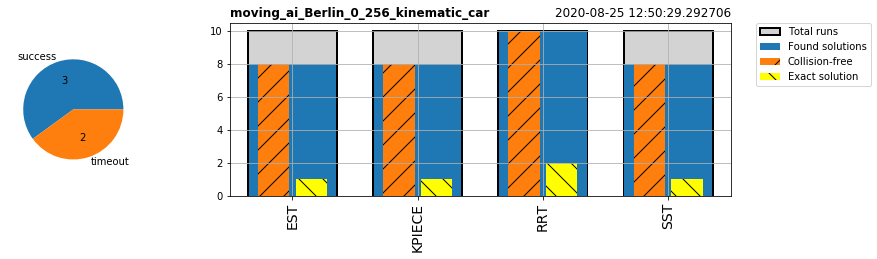

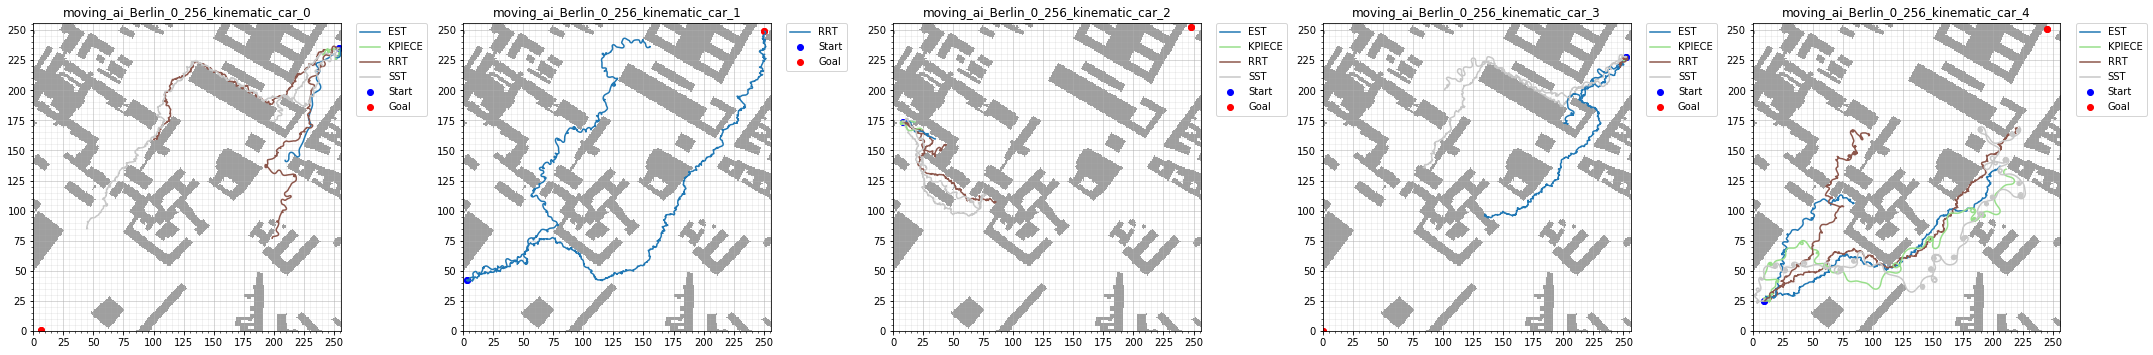

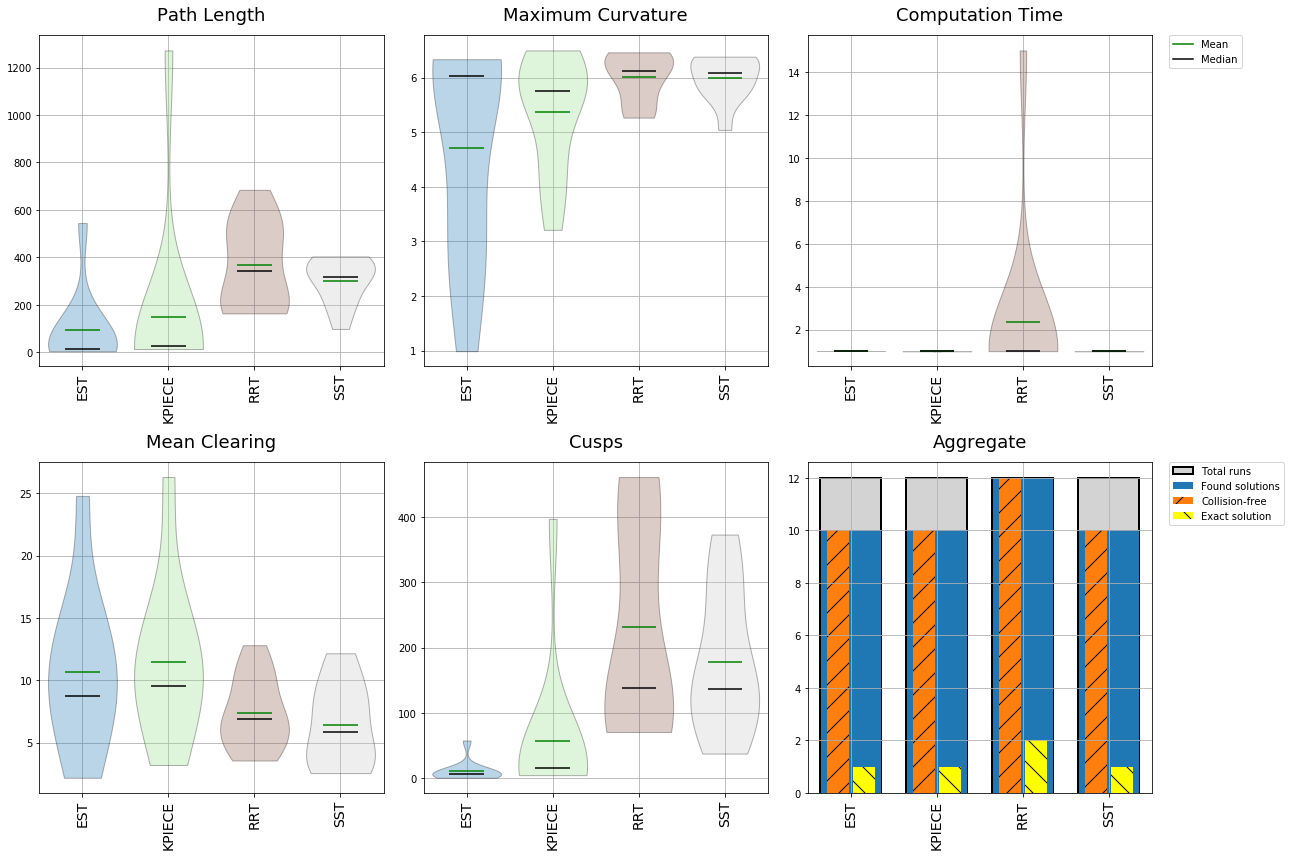

1.0
1.0
1.0
1.0
1.0
Available memory: 25.69 GB, limiting each MPB process to 62.5% usage (16.06 GB).
Creating pool of 5 processes.
Created MPB from config moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_1_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_0_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_3_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_2_config.json.
Created MPB from config moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_4_config.json.
Running MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_2 (log file at moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_2.log)...
Running MPB with ID moving_ai_B

Killed moving_ai_Berlin_0_256_kinematic_single_track_3 with planner fpkpiece after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_3 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_single_track_4 with planner fpsst after 30.00s exceeded timeout.
Killed moving_ai_Berlin_0_256_kinematic_single_track_2 with planner fpkpiece after 30.01s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_2 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_single_track_1 with planner fpest after 30.01s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_1 using planner FP EST.


Killed moving_ai_Berlin_0_256_kinematic_single_track_0 with planner fpkpiece after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_0 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_single_track_3 with planner fprrt after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_3 using planner FP RRT.


Killed moving_ai_Berlin_0_256_kinematic_single_track_1 with planner fpsst after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_1 using planner FP SST.


Killed moving_ai_Berlin_0_256_kinematic_single_track_4 with planner fpkpiece after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_4 using planner FP KPIECE.


Killed moving_ai_Berlin_0_256_kinematic_single_track_2 with planner fpsst after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_2 using planner FP SST.


Killed moving_ai_Berlin_0_256_kinematic_single_track_0 with planner fpest after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_0 using planner FP EST.


Killed moving_ai_Berlin_0_256_kinematic_single_track_3 with planner fpsst after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_3 using planner FP SST.


Killed moving_ai_Berlin_0_256_kinematic_single_track_1 with planner fpkpiece after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_1 using planner FP KPIECE.


Benchmark 1 (moving_ai_Berlin_0_256_kinematic_single_track_1) failed. Return code: -9.


Killed moving_ai_Berlin_0_256_kinematic_single_track_4 with planner fpest after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_4 using planner FP EST.


Benchmark 4 (moving_ai_Berlin_0_256_kinematic_single_track_4) failed. Return code: -9.


Killed moving_ai_Berlin_0_256_kinematic_single_track_2 with planner fpest after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_2 using planner FP EST.


Benchmark 2 (moving_ai_Berlin_0_256_kinematic_single_track_2) failed. Return code: -9.


Killed moving_ai_Berlin_0_256_kinematic_single_track_0 with planner fpsst after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_0 using planner FP SST.


Benchmark 0 (moving_ai_Berlin_0_256_kinematic_single_track_0) failed. Return code: -9.


Killed moving_ai_Berlin_0_256_kinematic_single_track_3 with planner fpest after 30.00s exceeded timeout.


Error (-9) occurred for MPB with ID moving_ai_Berlin_0_256_kinematic_single_track_3 using planner FP EST.


Benchmark 3 (moving_ai_Berlin_0_256_kinematic_single_track_3) failed. Return code: -9.
Error(s) occurred, not all benchmarks succeeded.
Benchmark 0 failed with return code -9. See log file moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_0.log.
Benchmark 1 failed with return code -9. See log file moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_1.log.
Benchmark 2 failed with return code -9. See log file moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_2.log.
Benchmark 3 failed with return code -9. See log file moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_3.log.
Benchmark 4 failed with return code -9. See log file moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_4.log.


Successfully merged [moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_0_results.json, moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_1_results.json, moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_2_results.json, moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_3_results.json, moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_4_results.json] into moving_ai_Berlin_0_256_kinematic_single_track/_total.json.
Visualizing moving_ai_Berlin_0_256_kinematic_single_track/_total.json...
Saved moving_ai_Berlin_0_256_kinematic_single_track/moving_ai_Berlin_0_256_kinematic_single_track_stats.pdf.


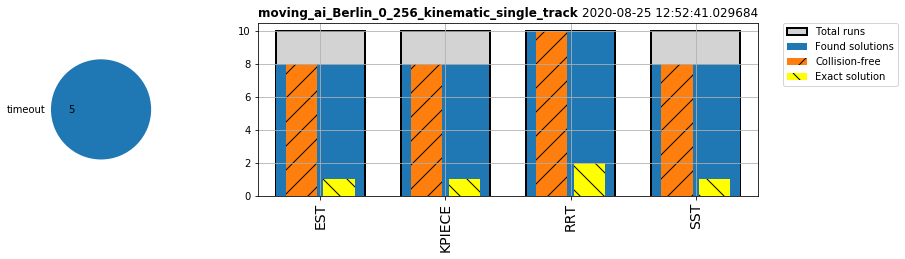

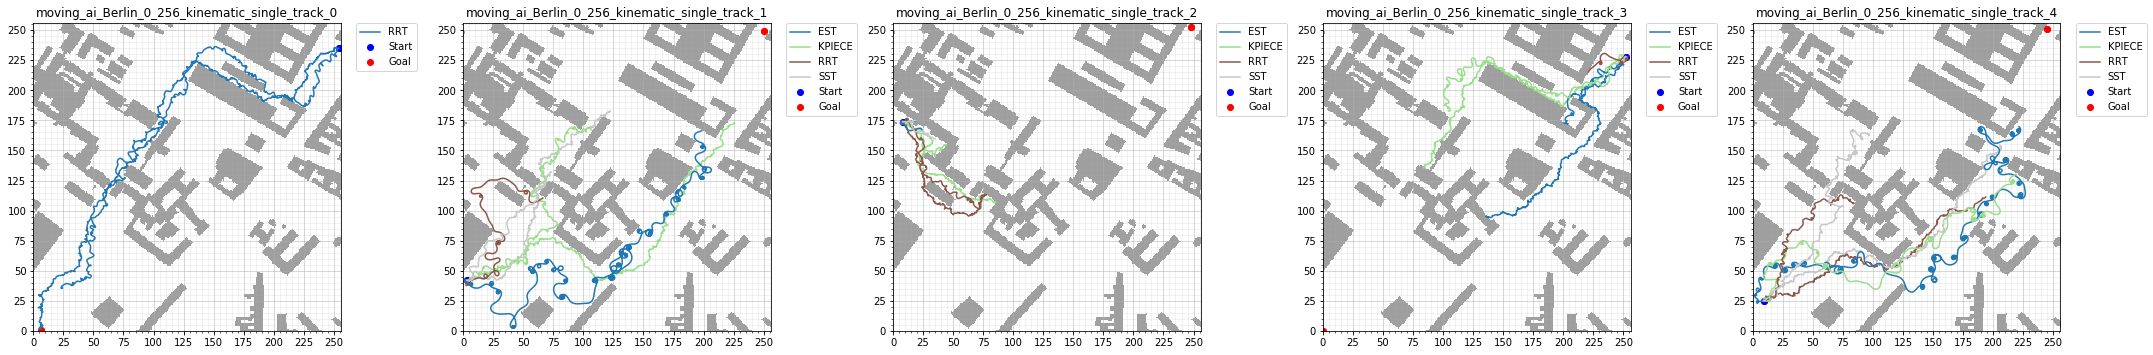

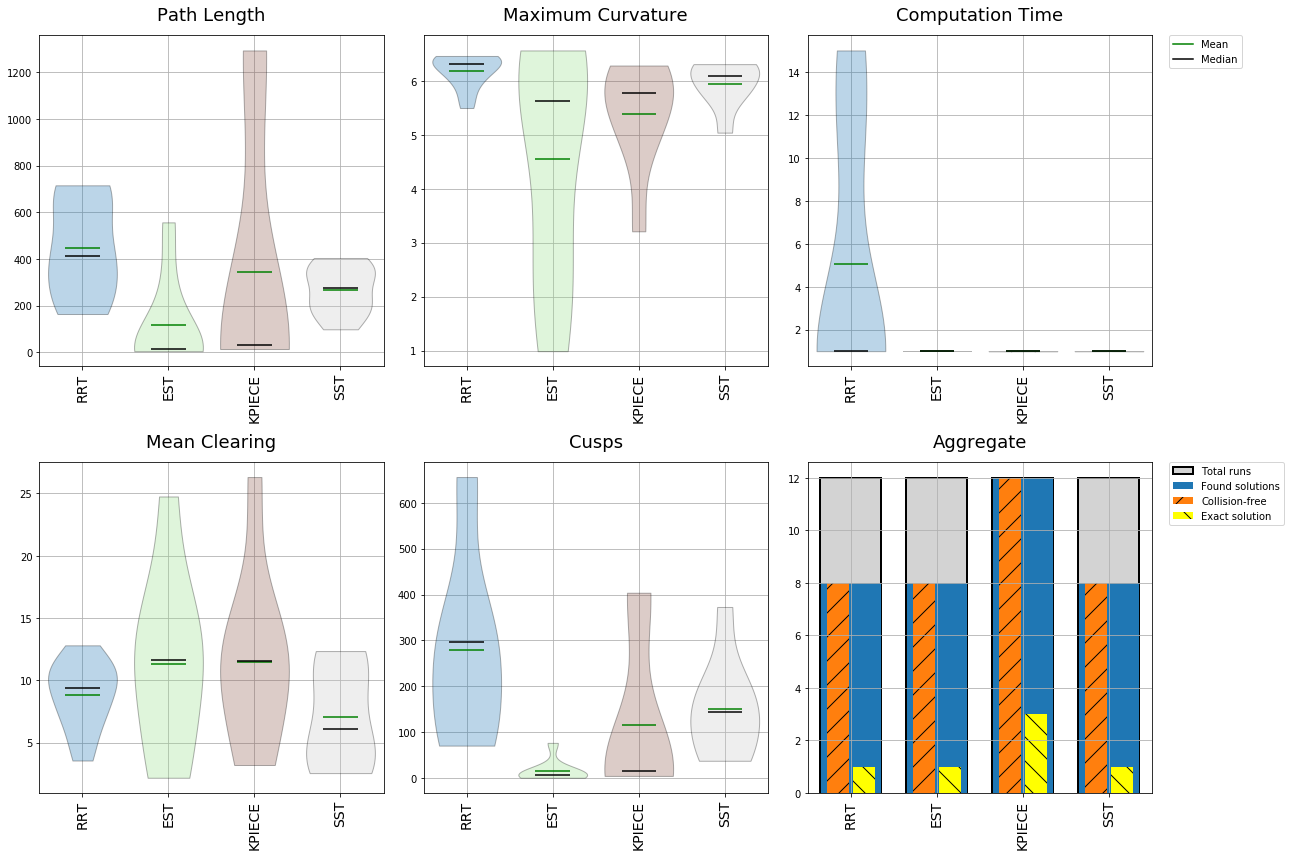

In [9]:
# Control based experiments
scenario = 'Berlin_0_256'
num_scenarios = 5

time_limit_multiplier = 1

robot_model_times = [
    ('kinematic_car', 15 * time_limit_multiplier),    
    ('kinematic_single_track', 15 * time_limit_multiplier)
]

for robot_model, time_limit in robot_model_times:
    benchmark_moving_ai_control_based(scenario, num_scenarios, robot_model, time_limit)

In [ ]:
scenario = 'NewYork_1_512'
num_scenarios = 50

time_limit_multiplier = 10

steer_function_times = [
    ('reeds_shepp', 15 * time_limit_multiplier),    
    ('dubins', 60 * time_limit_multiplier),    
    ('cc_reeds_shepp', 180 * time_limit_multiplier),    
    ('posq', 120 * time_limit_multiplier)
]

for steer_function, time_limit in steer_function_times:
    benchmark_moving_ai(scenario, num_scenarios, steer_function, time_limit)

In [ ]:
scenario = 'Boston_1_1024'
num_scenarios = 50

time_limit_multiplier = 30

steer_function_times = [
    ('reeds_shepp', 15 * time_limit_multiplier),    
    ('dubins', 60 * time_limit_multiplier),    
    ('cc_reeds_shepp', 1.5 * 60 * time_limit_multiplier),    
    ('posq', 120 * time_limit_multiplier)
]

for steer_function, time_limit in steer_function_times:
    benchmark_moving_ai(scenario, num_scenarios, steer_function, time_limit)

### Generate $\LaTeX$ table

In [ ]:
steer_function = 1
steer_name = steer_function_times[steer_function][0]
steer_time = steer_function_times[steer_function][1]
total_filename = 'moving_ai_%s_%s/_total.json' % (scenario, steer_name)
print(latex_table(total_filename,
                  row_label='%s (%s) [%d sec / %g min]' % (steer_name, scenario, steer_time, steer_time/60),
                  time_limit=steer_time))